In [ ]:
'''
Panagiotis Christakakis
'''

In [1]:
# Install libraries needed
!pip install dpkt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import Libraries
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import socket

In [4]:
filename='trace.pcap'

In [ ]:
# Define variables for counting protocols
counter = 0
tcp_counter = 0
udp_counter = 0
icmp_counter = 0 
arp_counter = 0

# Define list to store packet lengths
total_packet_lengths = []

# Define Dictionaries to store flow sizes for TCP & UDP packets
tcp_flows = {}  
udp_flows = {}

# Define Dictionaries to store grouped flows based on Source-Destination IPs and Ports for TCP & UDP packets
tcp_flows_dur = {}
udp_flows_dur = {}

# Define lists to store flow durations for TCP and UDP packets
tcp_durations = []
udp_durations = []


# Iterate through the contents of .pcap file
for timestamp, pkt in dpkt.pcap.Reader(open(filename,'rb')):

    # Unpack the Ethernet frame
    eth = dpkt.ethernet.Ethernet(pkt)
    counter += 1

    # ARP packet
    if isinstance(eth.data, dpkt.arp.ARP):
      arp = eth.data
      arp_counter += 1
      total_packet_lengths.append(len(arp))

    # Make sure the Ethernet data contains an IP packet (IPv4 and IPv6)
    if (isinstance(eth.data, dpkt.ip.IP) or isinstance(eth.data, dpkt.ip6.IP6)):

      # Grab the data within the Ethernet frame (the IP packet)
      ip = eth.data

      # Later we'll need to use Source-Destination IPs and Ports 
      # so it's needed to obtain them for both ipv4 and ipv6
      
      #IPv4
      try:
        src_ip = socket.inet_ntop(socket.AF_INET, ip.src)
      except ValueError:
        src_ip = socket.inet_ntop(socket.AF_INET6, ip.src)

      #IPv6
      try:
        dst_ip = socket.inet_ntop(socket.AF_INET, ip.dst)
      except ValueError:
        dst_ip = socket.inet_ntop(socket.AF_INET6, ip.dst)

      # Needed for the CDF of Package Size
      # Add the packet length to the list
      total_packet_lengths.append(len(ip))

      # TCP packet
      if isinstance(ip.data, dpkt.tcp.TCP):
          tcp = ip.data
          tcp_counter += 1
          
          # Needed for the CDF of Flow Sizes
          # Fill the dictionary with lenghts of the packets based on grouped
          # flow keys that contain Source-Destination IPs and Ports for TCP packets
          flow_size = len(pkt)
          flow = (ip.src, ip.dst, ip.data.sport, ip.data.dport)
          if flow in tcp_flows:
              tcp_flows[flow] += flow_size
          else:
              tcp_flows[flow] = flow_size
          
          # Needed for the CDF of Flow Durations
          # Create a grouped flow key based on Source-Destination IPs and Ports for TCP
          src_port = tcp.sport
          dst_port = tcp.dport
          flow_key = (src_ip, dst_ip, src_port, dst_port, 'TCP')

          # Check if we have already seen this flow
          if flow_key not in tcp_flows_dur:
              # If not, add it to the dictionary with it's 
              # starting timestamp and ending timestamp set to 0
              tcp_flows_dur[flow_key] = [timestamp, 0]
          else:
              # If yes, add the last timestamp to the flow
              tcp_flows_dur[flow_key][1] = timestamp

      # UDP packet
      elif isinstance(ip.data, dpkt.udp.UDP):
          udp = ip.data
          udp_counter += 1

          # Needed for the CDF of Flow Sizes
          # Fill the dictionary with lenghts of the packets based on grouped
          # flow keys that contain Source-Destination IPs and Ports for UDP packets
          flow_size = len(pkt)
          flow = (ip.src, ip.dst, ip.data.sport, ip.data.dport)
          if flow in udp_flows:
              udp_flows[flow] += flow_size
          else:
              udp_flows[flow] = flow_size

          # Needed for the CDF of Flow Durations
          # Create a grouped flow key based on Source-Destination IPs and Ports for UDP
          src_port = udp.sport
          dst_port = udp.dport
          flow_key = (src_ip, dst_ip, src_port, dst_port, 'UDP')

          # Check if we have already seen this flow
          if flow_key not in udp_flows_dur:
              # If not, add it to the dictionary with it's 
              # starting timestamp and ending timestamp set to 0
              udp_flows_dur[flow_key] = [timestamp, 0]
          else:
              # If yes, add the last timestamp to the flow
              udp_flows_dur[flow_key][1] = timestamp

      # ICMP packet
      elif isinstance(ip.data, dpkt.icmp.ICMP):
          icmp = ip.data
          icmp_counter += 1

# For debugging reasons
# print("Total number of packets in the pcap file: ", counter)
# print("Total number of TCP packets: ", tcp_counter)
# print("Total number of UDP packets: ", udp_counter)
# print("Total number of ICMP packets: ", icmp_counter)
# print("Total number of ARP packets: ", arp_counter)

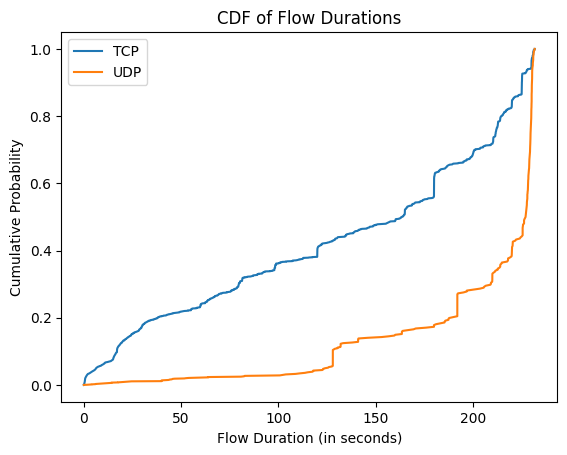

In [6]:
'''
1st Plot
'''

# Because some flows appear only once the tcp_flows_dur dictionary may have
# only one timestamp (i.e. [1261068567.644630000, 0]). Thats why it's mandatory
# to have two checking conditions in order not to get negative results. Then we
# substract the ending and starting timestamps and convert them into seconds.
# We do that for both TCP and UDP dictionaries. 
for flow_key in tcp_flows_dur:
    if tcp_flows_dur[flow_key][1] != 0:
      duration = (dt.datetime.utcfromtimestamp(tcp_flows_dur[flow_key][1]) - dt.datetime.utcfromtimestamp(tcp_flows_dur[flow_key][0])).total_seconds()
    else:
      duration = (dt.datetime.utcfromtimestamp(tcp_flows_dur[flow_key][0]) - dt.datetime.utcfromtimestamp(tcp_flows_dur[flow_key][0])).total_seconds()
    tcp_durations.append(duration)

for flow_key in udp_flows_dur:
    if udp_flows_dur[flow_key][1] != 0:
      duration = (dt.datetime.utcfromtimestamp(udp_flows_dur[flow_key][1]) - dt.datetime.utcfromtimestamp(udp_flows_dur[flow_key][0])).total_seconds()
    else:
      duration = (dt.datetime.utcfromtimestamp(udp_flows_dur[flow_key][0]) - dt.datetime.utcfromtimestamp(udp_flows_dur[flow_key][0])).total_seconds()
    udp_durations.append(duration)

# Compute the CDF for TCP flows
tcp_durations.sort()
tcp_cdf_dur = np.cumsum(tcp_durations) / sum(tcp_durations)

# Compute the CDF for UDP flows
udp_durations.sort()
udp_cdf_dur = np.cumsum(udp_durations) / sum(udp_durations)

# Plot the CDFs
fig, ax = plt.subplots()
ax.plot(tcp_durations, tcp_cdf_dur, label='TCP')
ax.plot(udp_durations, udp_cdf_dur, label='UDP')
ax.legend()
ax.set_title('CDF of Flow Durations')
ax.set_xlabel('Flow Duration (in seconds)')
ax.set_ylabel('Cumulative Probability')

# Save the plot
plt.savefig('FlowDurations-CDF.png', bbox_inches='tight')

# Show the plot
plt.show()

Comments: The above diagram shows that TCP flows follow a linear increase as the seconds pass, while UDP flows appear to follow an exponential increase from a certain point onwards. More specifically, the linear increase in the duration of TCP flows is expected, since TCP is a reliable protocol that guarantees data delivery. As a result, the duration of TCP flows will increase as data is transmitted over the link.

On the other hand, the exponential increase in the duration of UDP flows suggests that there are a large number of UDP flows with long lifetimes in the trace file. Unlike TCP, UDP is an unreliable protocol that does not guarantee data delivery. Therefore, UDP flows can have a wide range of durations and some flows may remain active for a long time. The sharp increase in the duration of UDP flows after 180 seconds suggests that 0.8 of the cumulative probability of UDP flows have a longer lifetime.

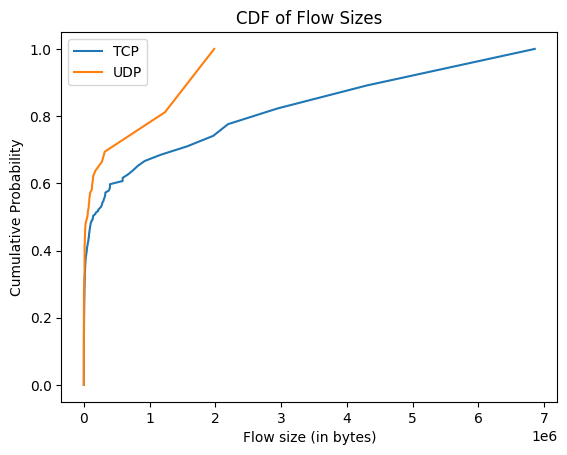

In [7]:
'''
2nd Plot
'''

# Compute the CDF for TCP flows
tcp_sizes = list(tcp_flows.values())
tcp_sizes.sort()
tcp_cdf = np.cumsum(tcp_sizes) / sum(tcp_sizes)

# Compute the CDF for UDP flows
udp_sizes = list(udp_flows.values())
udp_sizes.sort()
udp_cdf = np.cumsum(udp_sizes) / sum(udp_sizes)

# Plot the CDFs
fig, ax = plt.subplots()
ax.plot(tcp_sizes, tcp_cdf, label='TCP')
ax.plot(udp_sizes, udp_cdf, label='UDP')
ax.legend()
ax.set_title('CDF of Flow Sizes')
ax.set_xlabel('Flow size (in bytes)')
ax.set_ylabel('Cumulative Probability')

# Save the plot
plt.savefig('FlowSize-CDF.png', bbox_inches='tight')

# Show the plot
plt.show()

Comments: By plotting this CDF, we can see the percentage of network traffic consisting of small, medium and large flows for TCP and UDP protocols separately. More specifically for UDP packets, there is a sharp increase from 0 to 200,000 bytes representing 0.6 of the cumulative probability, which suggests that the majority of UDP flows are relatively small in size, which is common in many network traffic scenarios. This could be due to small control messages or data packets used for real-time applications such as VoIP. After 200,000 bytes to 2,000,000 bytes, there is a steady increase in the sizes of UDP flows.

The sharp increase in TCP flows from 0 to 250,000 bytes representing 0.6 of the cumulative probability suggests that a significant number of TCP flows are small in size. This indicates that half or more of the number of TCP flows are starting and ending quickly and carrying only a small amount of data, as is the case for UDP.

After 250,000 bytes, there is a steady increase in the size of TCP streams, indicating that there are TCP streams carrying large volumes of data. In fact, these far outnumber UDP flows by far, reaching 7,000,000 bytes, which could indicate relatively larger file-data transfers, video streams and application usage.

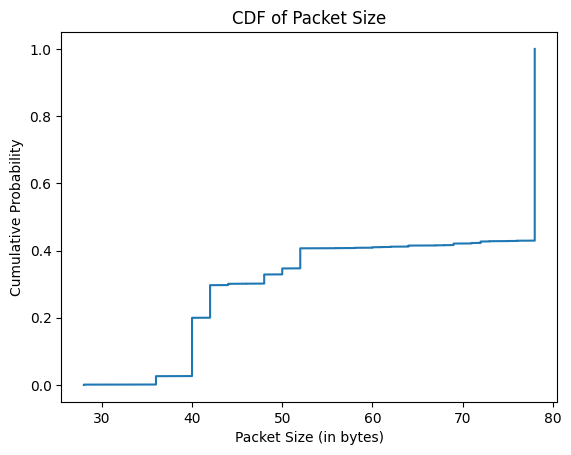

In [17]:
'''
3rd Plot
'''

# Convert and sort the list of packet lengths 
# to a NumPy array for easier manipulation
total_packet_lengths = np.array(total_packet_lengths)
total_sorted_lengths = np.sort(total_packet_lengths)

# Calculate the CDF
yvals = np.arange(len(total_sorted_lengths)) / float(len(total_sorted_lengths))

# Plot the CDF
plt.plot(total_sorted_lengths, yvals)
plt.title('CDF of Packet Size')
plt.xlabel('Packet Size (in bytes)')
plt.ylabel('Cumulative Probability')

# Save the plot
plt.savefig('PacketSize-CDF.png', bbox_inches='tight')

# Show the plot
plt.show()

Comments: the above diagram shows that 50% of the trace.pcap packets are up to ~55 bytes in size, while the other 50% are close to 80 bytes and possibly more. Also, it is important to note that in the interval 55 to ~78 bytes the cumulative probability has almost no increase which means that few packets take on these sizes. Overall, the CDF plot of packet sizes gives us information about their distribution in the flow set, which can help us understand the network traffic and identify potential problems or anomalies.

In the code the counting of protocols was done with several control commands. In the dpkt documentation and on the web in general, all available implementations included the if isinstance(eth.data, dpkt.ip.IP) check which checks if the given packet is of type IPv4. This got me interested to see if there were IPv6 packets in the trace.pcap file and after checking in Wireshark I saw that there were 16 UDP and 2 ICMP packets, which means that we would have missed them in the previous graphs if we didn't use if isinstance(eth.data, dpkt.ip.IP) or isinstance(eth.data, dpkt.ip6.IP6) as a check.

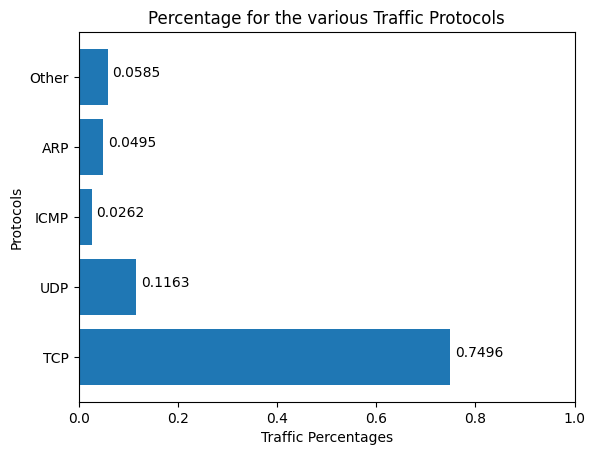

In [22]:
'''
4th Plot
'''

# Packet counters as percentages
tcp_percent = tcp_counter / counter
udp_percent = udp_counter / counter
icmp_percent = icmp_counter / counter
arp_percent = arp_counter / counter
other_counter = counter - (tcp_counter + udp_counter + icmp_counter + arp_counter)
other_percent = other_counter / counter

# Put the percentages in a list
percentages = [tcp_percent, udp_percent, icmp_percent, arp_percent, other_percent]

# Define the labels for the bar plot
labels = ['TCP', 'UDP', 'ICMP', 'ARP', 'Other']

# Create the bar plot
plt.barh(labels, percentages)

# Add a title and labels to the plot
plt.title('Percentage for the various Traffic Protocols')
plt.xlabel('Traffic Percentages')
plt.ylabel('Protocols')
plt.xlim([0, 1])

# Add text next to each bar
for i, v in enumerate(percentages):
    plt.text(v + 0.01, i, str(round(v, 4)))

# Save the plot
plt.savefig('Traffic-Percentages.png', bbox_inches='tight')

# Show the plot
plt.show()

Comments: Based on the above percentages, it appears that TCP is the most dominant protocol in network traffic, accounting for almost 75% of all traffic. UDP is the second most used protocol with 11.63%, while ARP and ICMP protocols are less used, accounting for 4.95% and 2.62% of traffic respectively. The remaining 5.85% of traffic is attributed to other protocols.

This information can be useful in understanding the nature of the network traffic recorded in the trace.pcap file. For example, a high percentage of TCP traffic indicates that the network may be used primarily for data transfer or communication between network devices. The presence of ARP and ICMP protocols may indicate network maintenance or troubleshooting activities, since one is used for IP address to MAC address mappings and the other for error reporting and mainly diagnostic purposes. Such a representation of the distribution of protocols can help us in identifying potential network problems as well as perhaps optimizing network performance.